# Lab 6: Random Forest Regression on Malagasy Mammal Traits

### Introduction
 In Lab 5, we used functional trait data on bird species to predict their presence in a given climate type. This week we are using regression tree models on a similar dataset, this one on mammal species.  Our goal is to predict the total number of climate types each mammal species inhabits.

You will compare performance of a single decision tree with a tuned random forest to get a sense of the effectiveness of ensemble methods with optimized hyperparameter values.

There is a fair amount of missing data in this set, which can lead to low reliability of feature splits, increased overfitting, and decreased accuracy of tree models. You will address this issue with a combination of variable omission and imputation.


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

### Step 1: Read data and retain a subset of the columns
Similar to last week, we will need to take some steps to get the data in a usable form. We again reformat the diet-related variable names to match this set: `Diet_Vertebrates`,
    `Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`. Then drop columns that are not relevant functional traits or climate type variables.   Next, drop any remaining  variables that have greater than 40% of the observations missing. Print the final dataframe shape. 

In [20]:
# Read in mammal species data
dat = pd.read_csv(
    "/courses/EDS232/Data/MamTraitData.csv", encoding="ISO-8859-1"
).rename(
    columns={
        "Diet: invertebrates": "Diet_Invertebrates",
        "Diet: vertebrates": "Diet_Vertebrates",
        "Diet: fruits": "Diet_Fruits",
        "Diet: flower/nectar/pollen/gums": "Diet_Flowers",
        "Diet: seeds": "Diet_Seeds",
        "Diet: other plant materials": "Diet_Plants",
        "Diet: scavenge; garbage; carrion; carcasses": "Diet_Other",
    }
)

# Count number of NAs
dat = dat.replace([-999, "-999"], np.nan)
dat.isna().sum()

# Drop columns where >40% of observations are missing
dat = dat.drop(
    columns=[
        "CranialCapacity",
        "GestationLength",
        "InterbirthInterval",
        "HomeRange",
        "PopulationDensity",
        "SocialGrpSize",
        "Longevity",
    ]
)

# print(f"Final DataFrame shape: {dat.shape}")
dat.shape

(214, 17)

### Step 2: Imputation with KNN
Now impute the values of the missing data in the remaining numeric columns using k-nearest neighbors with `KNNImputer()`. Use the 5 nearest neighbors. This allows us to implement the knn algorithm to predict the missing values for an observation based on similar complete observations.Perform and print a check to ensure that there are no more NA values. 

In [21]:
dat.isna().sum()

AdultBodyMass          3
Diet_Invertebrates    15
Diet_Vertebrates      15
Diet_Fruits           15
Diet_Flowers          15
Diet_Seeds            15
Diet_Plants           15
Diet_Other            15
HabitatBreadth        26
ActivityCycle         22
ForagingStratum       24
LitterSize            83
Dry                    0
Humid                  0
Montane                0
Subarid                0
Subhumid               0
dtype: int64

In [22]:
dat.dtypes

AdultBodyMass         float64
Diet_Invertebrates     object
Diet_Vertebrates       object
Diet_Fruits            object
Diet_Flowers           object
Diet_Seeds             object
Diet_Plants            object
Diet_Other             object
HabitatBreadth        float64
ActivityCycle         float64
ForagingStratum       float64
LitterSize            float64
Dry                     int64
Humid                   int64
Montane                 int64
Subarid                 int64
Subhumid                int64
dtype: object

In [ ]:
# Check number of missing values
dat.isna().sum()

# Impute missing categorical data using mode
categorical_cols = dat.select_dtypes("object")
categorical_cols = categorical_cols.fillna(categorical_cols.mode().iloc[0])

# Impute numerical columns with KNN Imputer
numerical_cols = dat.select_dtypes("number")
knn_impute = KNNImputer(n_neighbors=5)
X_knn_impute = knn_impute.fit_transform(dat.select_dtypes(include="number"))
X_knn_impute = pd.DataFrame(X_knn_impute, columns=numerical_cols.columns)

# Check for missing values
print(X_knn_impute.isna().sum())
print(categorical_cols.isna().sum())


AdultBodyMass      0
HabitatBreadth     0
ActivityCycle      0
ForagingStratum    0
LitterSize         0
Dry                0
Humid              0
Montane            0
Subarid            0
Subhumid           0
dtype: int64
Diet_Invertebrates    0
Diet_Vertebrates      0
Diet_Fruits           0
Diet_Flowers          0
Diet_Seeds            0
Diet_Plants           0
Diet_Other            0
dtype: int64


### Step 3: Create target variable and numerical encoding 
Create the target variable (`nClimates`) representing the  number of climates in which a species was present. Then finish preparing the data to be used in our models.

- Create a new column `nClimates` that combines the information of the five climate type variables
- Drop the original `Dry`, `Humid`, `Montane`, `Subarid`, and `Subhumid` columns
- Encode categorical variables
- Split the dataset into training and test sets. Use a random state of 808. 

In [ ]:
# Create a new column that combines the information of the 5 climate type variables
X_knn_impute["nclimates"] = X_knn_impute[
    ["Dry", "Humid", "Montane", "Subarid", "Subhumid"]
].sum(axis=1)

# Drop original climate columns
X_knn_impute = X_knn_impute.drop(
    columns=["Dry", "Humid", "Montane", "Subarid", "Subhumid"]
)
X_knn_impute


,AdultBodyMass,HabitatBreadth,ActivityCycle,ForagingStratum,LitterSize,nclimates
0,78.00,1.0,2.0,3.0,1.000,3.0
1,1082.00,1.0,1.0,3.0,1.402,2.0
2,946.00,2.0,1.0,3.0,4.692,1.0
3,1180.00,2.0,1.0,3.0,1.010,4.0
4,1212.50,1.0,1.0,3.0,1.540,3.0
...,...,...,...,...,...,...
209,8.50,2.0,1.0,4.0,1.668,5.0
210,3019.00,1.0,3.0,3.0,2.600,1.0
211,3524.00,2.0,2.0,3.0,2.030,2.0
212,21.80,1.0,1.0,2.2,2.600,2.0


In [25]:
# Encode categorical variables
for col in categorical_cols:
    label_encoder = LabelEncoder()
    categorical_cols[col] = label_encoder.fit_transform(categorical_cols[col])

In [26]:
# Concatenate the categorical and numerical columns horizontally
dat_clean = pd.concat([categorical_cols, X_knn_impute], axis=1)
dat_clean

# Define features and target
X = dat_clean.drop(columns=["nclimates"])
y = dat_clean[["nclimates"]]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=808
)

In [27]:
dat_clean.head()

,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,AdultBodyMass,HabitatBreadth,ActivityCycle,ForagingStratum,LitterSize,nclimates
0,1,0,1,1,0,1,0,78.0,1.0,2.0,3.0,1.000,3.0
1,0,0,1,0,0,1,0,1082.0,1.0,1.0,3.0,1.402,2.0
2,0,0,1,0,0,1,0,946.0,2.0,1.0,3.0,4.692,1.0
3,0,0,1,0,0,1,0,1180.0,2.0,1.0,3.0,1.010,4.0
4,0,0,1,0,0,1,0,1212.5,1.0,1.0,3.0,1.540,3.0


### Step 4: Train a decision tree
Train a single decision tree to predict the number of climate types inhabited by each species.

- Train a `DecisionTreeRegressor`.  Let's apply a constraint on its growth by not allowing the tree to grow further than 5 levels. Use a random state of 808. 
- Make predictions
- Visualize the decision tree using `plot_tree`
- Evaluate and print its performance using mse

In [28]:
# Initialize and fit DecisionTreeRegressor
regressor = DecisionTreeRegressor(
    max_depth=5,
    random_state=808,
)
regressor.fit(X_train, y_train)

# Make predictions on training and test data
y_train_pred = regressor.predict(X_train)
y_pred = regressor.predict(X_test)

# Evaluate model use mean squared error
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_pred)
print(f"Training MSE: {train_mse:.3f}")
print(f"Test MSE: {test_mse:.3f}")

Training MSE: 0.804
Test MSE: 2.045


In [29]:
# Visualize decision tree
plt.figure(figsize=(12, 15), dpi=700)
plot_tree(regressor, feature_names=X.columns, filled=True, rounded=True)
plt.title("Decision Tree")
plt.show()

Based on the way this tree looks, what would you guess the most important variable to be?

`Diet_Plants`, since it is the stump of the tree.

### Step 5: Random forest with hyperparameter tuning
Now we'll use a more sophisticated ensemble approach where we optimize the values of key hyperparameters that govern tree growth.

- Define a parameter grid that includes the follow parameters and values:
  -  (sqrt(p), 6, and no set #) of the number of features to try at each split
  -  (50, 100, 200) total trees (learners)
  -  a maximum tree depth of (3,4,5,6,7)
  -  (2,5,10) minimum samples per split
  -  (1,2,4) minimum samples per leaf
  
- Use `GridSearchCV` with 5-fold cross-validation and mse (`neg_mean_squared_error`) to find the best combination of parameter values
- Train the best estimator.

In [ ]:
# Define RandomForestRegressor
rf = RandomForestRegressor(random_state=808)

# Define hyperparameter distributions
param_grid = {
    "max_features": ["sqrt", 6, None],
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 4, 5, 6, 7],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

# Fit the GridSearchCV object to the data
grid_search = GridSearchCV(
    rf, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error"
)
grid_search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=808),
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'max_features': ['sqrt', 6, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [31]:
# Get the best estimator
best_rf = grid_search.best_estimator_
best_rf

RandomForestRegressor(max_depth=7, max_features='sqrt', min_samples_split=5,
                      n_estimators=200, random_state=808)

### Step 6: Make predictions and evaluate random forest model
Use the optimized random forest model (`best_rf`) to predict the number of climates a species inhabits and analyze its performance.

- Use `best_rf` and `predict()` method on `X_test` to generate predictions
- Print the best set of parameter values using thte `best_params` method
- Compute and print the mse to evaluate model performance
- Extract feature importance from the trained random forest model
- Visualize feature importance using a bar plot

Best parameters: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Test MSE: 1.468


Text(0, 0.5, 'Features')

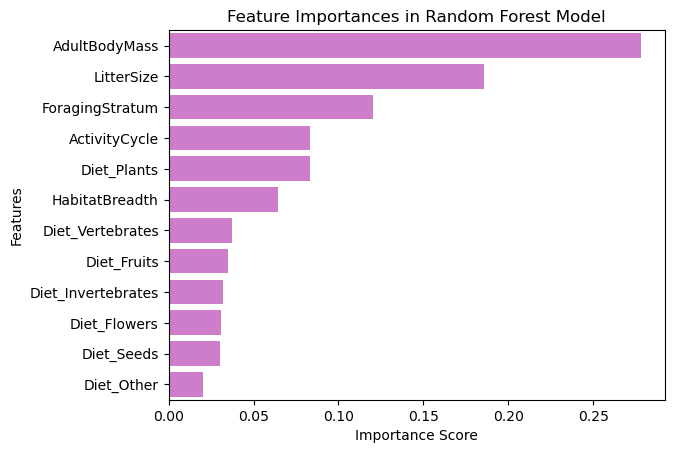

In [34]:
# Generate predictions
best_y_pred = best_rf.predict(X_test)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# Compute and print mean squared error
test_mse_best = mean_squared_error(y_test, best_y_pred)
print(f"Test MSE: {test_mse_best:.3f}")

# Extract feature importance
feat_importances = pd.Series(best_rf.feature_importances_, index=X.columns)
feat_importances_df = feat_importances.reset_index()
feat_importances_df.columns = ["Feature", "Importance"]
feat_importances_df = feat_importances_df.sort_values('Importance', ascending=False)

# Plot feature importance using a barplot
sns.barplot(
    data=feat_importances_df,
    x="Importance",
    y="Feature",
    color="orchid",
)
plt.title("Feature Importances in Random Forest Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")

Which model had better accuracy, the single tree or the ensemble.  Interpret which traits have the most influence on species' climate adaptability.

The ensemble model had a lower MSE (Test MSE: 1.468) compared to the single tree (Test MSE: 2.045), which means it had better accuracy. Adult body mass, litter size, and foraging stratum had the most influence on species' climate adaptability in the ensemble model, while a plant diet had the most influence in the single tree model.